# Train a Vision Transformer on small datasets

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2022/01/07<br>
**Last modified:** 2022/01/10<br>
**Description:** Training a ViT from scratch on smaller datasets with shifted patch tokenization and locality self-attention.

## Introduction

In the academic paper
[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929),
the authors mention that Vision Transformers (ViT) are data-hungry. Therefore,
pretraining a ViT on a large-sized dataset like JFT300M and fine-tuning
it on medium-sized datasets (like ImageNet) is the only way to beat
state-of-the-art Convolutional Neural Network models.

The self-attention layer of ViT lacks **locality inductive bias** (the notion that
image pixels are locally correlated and that their correlation maps are translation-invariant).
This is the reason why ViTs need more data. On the other hand, CNNs look at images through
spatial sliding windows, which helps them get better results with smaller datasets.

In the academic paper
[Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1),
the authors set out to tackle the problem of locality inductive bias in ViTs.

The main ideas are:

- **Shifted Patch Tokenization**
- **Locality Self Attention**

This example implements the ideas of the paper. A large part of this
example is inspired from
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

_Note_: This example requires TensorFlow 2.6 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons), which can be
installed using the following command:

```python
pip install -qq -U tensorflow-addons
```

## Setup

In [28]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [29]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [30]:
from collections import Counter
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime

## Getting Data (If it is saved earlier)

In [31]:
# input_shape = (32, 32, 3)
# boyut = (32,32)


## Configure the hyperparameters

The hyperparameters are different from the paper. Feel free to tune
the hyperparameters yourself.

In [32]:
# IMAGE
RAW_IMG_SIZE = 128
NUM_CLASSES = 268
INPUT_SHAPE = (RAW_IMG_SIZE, RAW_IMG_SIZE, 3)
SPLIT_SEED = 103

# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = RAW_IMG_SIZE
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 120

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [33]:
pathh='C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\Veriler\\hepsi\\5\\128'
y_train_aug_le= np.loadtxt(pathh+'/y_train_aug_le.txt', dtype=float)
y_train_aug_cat= np.loadtxt(pathh+'/y_train_aug_cat.txt', dtype=float)
y_val_le= np.loadtxt(pathh+'/y_val_le.txt', dtype=float)
y_val_cat= np.loadtxt(pathh+'/y_val_cat.txt', dtype=float)
y_test_le= np.loadtxt(pathh+'/y_test_le.txt', dtype=float)
y_test_cat= np.loadtxt(pathh+'/y_test_cat.txt', dtype=float)
x_train= np.load(pathh+'/x_train.npy')
x_val= np.load(pathh+'/x_val.npy')
x_test= np.load(pathh+'/x_test.npy')
y_test= np.load(pathh+'/y_test.npy')
y_val= np.load(pathh+'/y_val.npy')
y_train= np.load(pathh+'/y_train.npy')

In [34]:
print(x_train[0].shape == (IMAGE_SIZE, IMAGE_SIZE, 3))

True


In [35]:
x_train.shape
x_val.shape
print(x_train.shape)
print(y_train.shape)

(17536, 128, 128, 3)
(17536, 1)


## Use data augmentation

A snippet from the paper:

*"According to DeiT, various techniques are required to effectively
train ViTs. Thus, we applied data augmentations such as CutMix, Mixup,
Auto Augment, Repeated Augment to all models."*

In this example, we will focus solely on the novelty of the approach
and not on reproducing the paper results. For this reason, we
don't use the mentioned data augmentation schemes. Please feel
free to add to or remove from the augmentation pipeline.

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        # layers.RandomFlip("horizontal_and_vertical"),
        # layers.RandomRotation(factor=0.02),
        # layers.GaussianNoise(0.3),
        # layers.RandomBrightness(0.002),
        # layers.RandomContrast(0.002)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


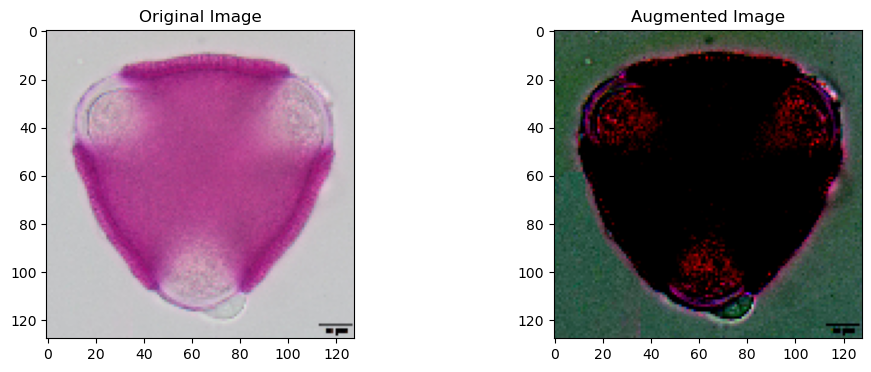

1


In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data to visualize
x = x_train[0]

# Augment the data
augmented_data = data_augmentation(x)

# Visualize the original and augmented data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].imshow(x)
axes[0].set_title("Original Image")

axes[1].imshow(augmented_data[0])
axes[1].set_title("Augmented Image")

plt.show()
print(len(augmented_data))

## Implement Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are
then linearly projected into tokens. Shifted patch tokenization (STP)
is introduced to combat the low receptive field of ViTs. The steps
for Shifted Patch Tokenization are as follows:

- Start with an image.
- Shift the image in diagonal directions.
- Concat the diagonally shifted images with the original image.
- Extract patches of the concatenated images.
- Flatten the spatial dimension of all patches.
- Layer normalize the flattened patches and then project it.

| ![Shifted Patch Toekenization](https://i.imgur.com/bUnHxd0.png) |
| :--: |
| Shifted Patch Tokenization [Source](https://arxiv.org/abs/2112.13492v1) |

In [38]:

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)
    
    def get_config(self):

            config = super().get_config().copy()
            config.update({
                'image_size': self.image_size,
                'patch_size': self.patch_size,
                'vanilla': self.vanilla,
            })
            return config


### Visualize the patches

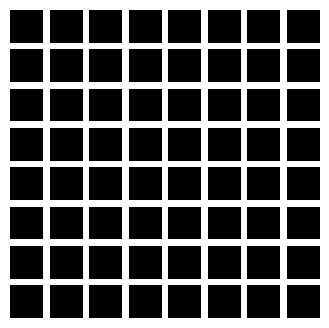

ORIGINAL


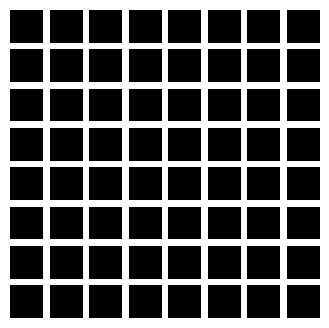

LEFT-UP


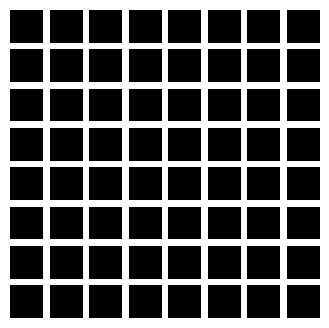

LEFT-DOWN


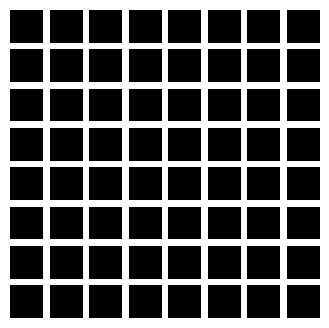

RIGHT-UP


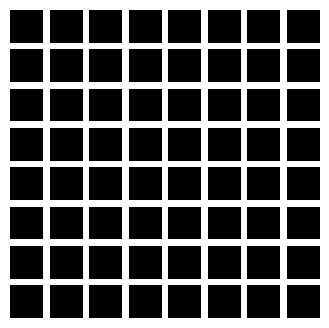

RIGHT-DOWN


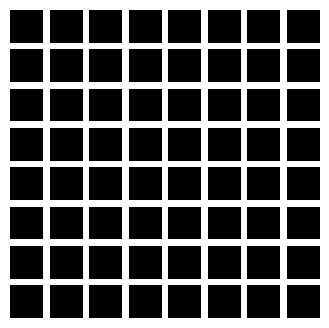

In [39]:
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## Implement the patch encoding layer

This layer accepts projected patches and then adds positional
information to them.

In [40]:

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches
    
    def get_config(self):

            config = super().get_config().copy()
            config.update({
                'num_patches': self.num_patches,
            })
            return config

## Implement Locality Self Attention

The regular attention equation is stated below.

| ![Equation of attention](https://miro.medium.com/max/396/1*P9sV1xXM10t943bXy_G9yg.png) |
| :--: |
| [Source](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634) |

The attention module takes a query, key, and value. First, we compute the
similarity between the query and key via a dot product. Then, the result
is scaled by the square root of the key dimension. The scaling prevents
the softmax function from having an overly small gradient. Softmax is then
applied to the scaled dot product to produce the attention weights.
The value is then modulated via the attention weights.

In self-attention, query, key and value come from the same input.
The dot product would result in large self-token relations rather than
inter-token relations. This also means that the softmax gives higher
probabilities to self-token relations than the inter-token relations.
To combat this, the authors propose masking the diagonal of the dot product.
This way, we force the attention module to pay more attention to the
inter-token relations.

The scaling factor is a constant in the regular attention module.
This acts like a temperature term that can modulate the softmax function.
The authors suggest a learnable temperature term instead of a constant.

| ![Implementation of LSA](https://i.imgur.com/GTV99pk.png) |
| :--: |
| Locality Self Attention [Source](https://arxiv.org/abs/2112.13492v1) |

The above two pointers make the Locality Self Attention. We have subclassed the
[`layers.MultiHeadAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
and implemented the trainable temperature. The attention mask is built
at a later stage.

In [41]:

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


## Implement the MLP

In [42]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Build the ViT

In [43]:

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [44]:
vanilla_mi = True
vit = create_vit_classifier(vanilla=vanilla_mi)

## Compile, train, and evaluate the mode

In [45]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model, vanilla):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            tfa.metrics.CohenKappa(num_classes=268, sparse_labels=True)
        ],
    )

    kayit_adresi = "C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\model_kayitlari_bittik2"
    if not os.path.exists(kayit_adresi):
        os.mkdir(kayit_adresi)

    zaman = datetime.today().strftime('%d-%m-%Y-%H-%M')
    model_kayit_noktasi_adresi = os.path.join(kayit_adresi,zaman)
    os.mkdir(model_kayit_noktasi_adresi)
    
    
    # kayit adresleri
    checkpoint_filepath  = os.path.join(model_kayit_noktasi_adresi,"model.hdf5")

    # CHECKPOINT
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = False,
    monitor='val_accuracy',
    save_best_only = True)

    # LRR
    lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',  
    factor=.1,  # Factor by which learning rate will be reduced
    patience=20,
    min_lr=1e-5)

    callbacks = [ checkpoint_callback, lrr]

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=EPOCHS,
        validation_data=(x_val,y_val),
        callbacks=callbacks
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy, kappa_score= model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    print(f"Kappa Score:{kappa_score}")

    # txt_kayit_adresi    = os.path.join(model_kayit_noktasi_adresi, f"agumentasyon_modeli.txt")
    # try:
    #     with open(txt_kayit_adresi, "w") as fh:
    #         fh.write(f"Vanilla: {vanilla}\nEpok sayisi: {EPOCHS}\nbasarisi: Test accuracy: {round(accuracy * 100, 2)}%\nCohenKappa Skoru: {kappa_score}\nResim Boyutu: {IMAGE_SIZE}\nPatch Boyutu: {PATCH_SIZE}\nTest top 5 accuracy: {round(top_5_accuracy * 100, 2)}%\n loss='categorical_crossentropy' metrics=['accuracy']\n{pathh}\n")
    #         data_augmentation.summary(print_fn=lambda x: fh.write(x + '\n'))

    # except Exception as e2:
    #     print("Model txt ye yazdirilamadi, hata: ", e2)


    return history, model_kayit_noktasi_adresi, round(accuracy * 100, 2), round(top_5_accuracy * 100, 2), kappa_score, model




# Run experiments with the vanilla ViT
vanilla_mi = True
vit = create_vit_classifier(vanilla=vanilla_mi)
history, model_kayit_noktasi_adresi, acc, top_5_accuracy, kappa_score, model = run_experiment(vit, vanilla_mi)

Epoch 1/120
137/137 [==============================] - 11s 41ms/step - loss: 4.8713 - accuracy: 0.0644 - top-5-accuracy: 0.1933 - cohen_kappa: 0.0489 - val_loss: 4.2342 - val_accuracy: 0.0940 - val_top-5-accuracy: 0.2963 - val_cohen_kappa: 0.0855 - lr: 0.0010
Epoch 2/120
137/137 [==============================] - 4s 31ms/step - loss: 3.8347 - accuracy: 0.1446 - top-5-accuracy: 0.3809 - cohen_kappa: 0.1323 - val_loss: 3.3283 - val_accuracy: 0.2051 - val_top-5-accuracy: 0.5071 - val_cohen_kappa: 0.1995 - lr: 0.0010
Epoch 3/120
137/137 [==============================] - 4s 31ms/step - loss: 3.1929 - accuracy: 0.2242 - top-5-accuracy: 0.5140 - cohen_kappa: 0.2144 - val_loss: 2.6369 - val_accuracy: 0.3419 - val_top-5-accuracy: 0.6467 - val_cohen_kappa: 0.3381 - lr: 0.0010
Epoch 4/120
137/137 [==============================] - 4s 31ms/step - loss: 2.7166 - accuracy: 0.3069 - top-5-accuracy: 0.6133 - cohen_kappa: 0.2987 - val_loss: 2.1844 - val_accuracy: 0.4387 - val_top-5-accuracy: 0.7436 - 

In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix

#Load the predicted labels and true labels
y_pred = model.predict(x_test)  # Load your predicted labels
y_true = y_test  # Load your true labels

#Create the confusion matrix
cm = confusion_matrix(y_true, y_pred.argmax(axis=-1))

tp = np.diag(cm)
fp = np.sum(cm, axis=0) - tp
fn = np.sum(cm, axis=1) - tp

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

arr_replaced = np.nan_to_num(f1, nan=0)
#Print the F1 score
print("F1 Score:", np.mean(arr_replaced))

11/11 [==============================] - 1s 8ms/step
F1 Score: 0.8062630570093258


C:\Users\PC\AppData\Local\Temp\ipykernel_9724\1454713841.py:15: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\PC\AppData\Local\Temp\ipykernel_9724\1454713841.py:17: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


In [47]:
txt_kayit_adresi    = os.path.join(model_kayit_noktasi_adresi, f"agumentasyon_modeli.txt")
try:
    with open(txt_kayit_adresi, "w") as fh:
        fh.write(f"Epok sayisi: {EPOCHS}\nbasarisi: Test accuracy: {acc}%\nCohenKappa Skoru: {kappa_score}\nF1 Skor: {np.mean(arr_replaced)}\nResim Boyutu: {IMAGE_SIZE}\nPatch Boyutu: {PATCH_SIZE}\nTest top 5 accuracy: {top_5_accuracy}%\n{pathh}\n")
        

except Exception as e2:
    print("Model txt ye yazdirilamadi, hata: ", e2)

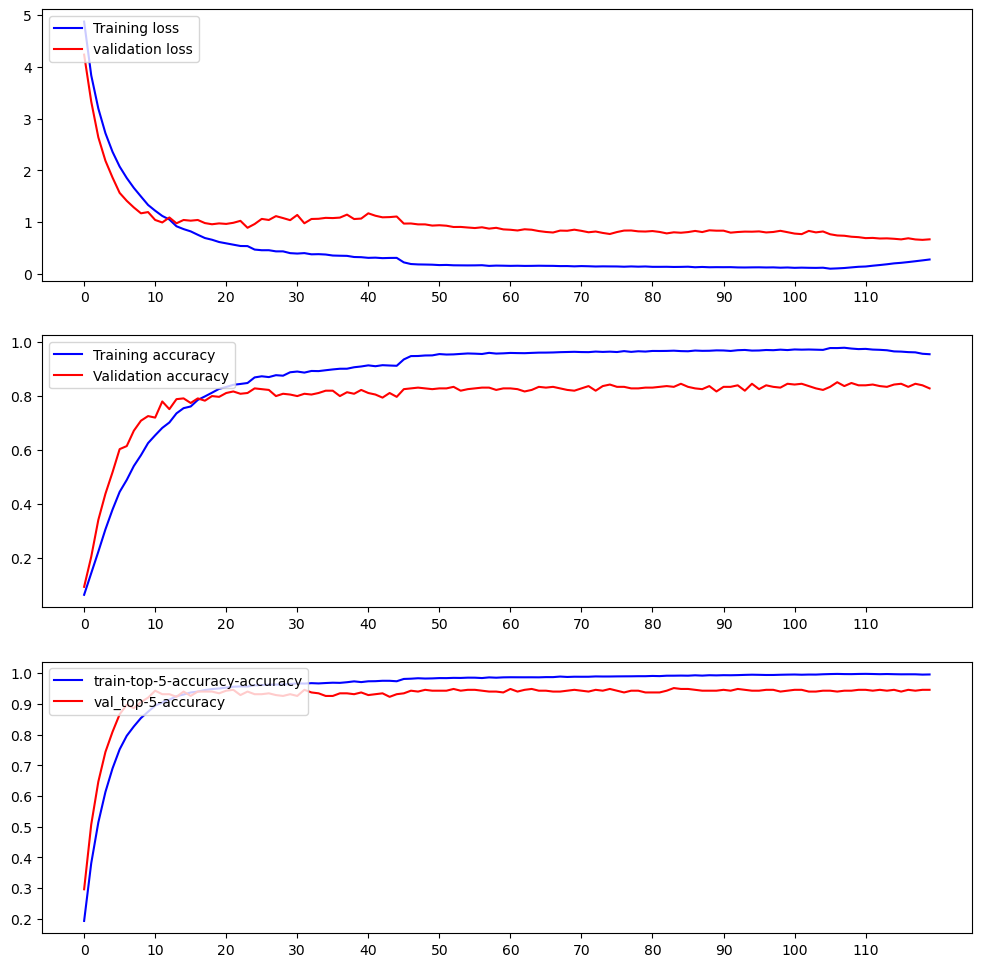

In [48]:
grafik_adresi = os.path.join(model_kayit_noktasi_adresi, "Grafik.png")

try:
        
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(0, EPOCHS, 10))
    ax1.legend(loc='upper left')

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(0, EPOCHS, 10))
    ax2.legend(loc='upper left')

    ax3.plot(history.history['top-5-accuracy'], color='b',label="train-top-5-accuracy-accuracy")
    ax3.plot(history.history['val_top-5-accuracy'], color='r',label="val_top-5-accuracy")
    ax3.set_xticks(np.arange(0, EPOCHS, 10))
    ax3.legend(loc='upper left')
    plt.savefig(grafik_adresi, bbox_inches='tight', facecolor='w')
    plt.show()

except Exception as e:
    print(f"Grafik çizilemedi {e}")

In [ ]:
# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history, model_kayit_noktasi_adresi = run_experiment(vit_sl, vanilla=False)

Epoch 1/200
35/35 [==============================] - 19s 168ms/step - loss: 6.6801 - accuracy: 0.0237 - top-5-accuracy: 0.0812 - val_loss: 5.1255 - val_accuracy: 0.0541 - val_top-5-accuracy: 0.1282 - lr: 0.0010
Epoch 2/200
35/35 [==============================] - 3s 90ms/step - loss: 5.1109 - accuracy: 0.0593 - top-5-accuracy: 0.1597 - val_loss: 4.9057 - val_accuracy: 0.0627 - val_top-5-accuracy: 0.1538 - lr: 0.0010
Epoch 3/200
35/35 [==============================] - 3s 89ms/step - loss: 4.8308 - accuracy: 0.0684 - top-5-accuracy: 0.2235 - val_loss: 4.8812 - val_accuracy: 0.0741 - val_top-5-accuracy: 0.2165 - lr: 0.0010
Epoch 4/200
35/35 [==============================] - 3s 89ms/step - loss: 4.4731 - accuracy: 0.0940 - top-5-accuracy: 0.2947 - val_loss: 4.7881 - val_accuracy: 0.0940 - val_top-5-accuracy: 0.2165 - lr: 0.0010
Epoch 5/200
35/35 [==============================] - 4s 102ms/step - loss: 4.2306 - accuracy: 0.1259 - top-5-accuracy: 0.3358 - val_loss: 4.4456 - val_accuracy: 0

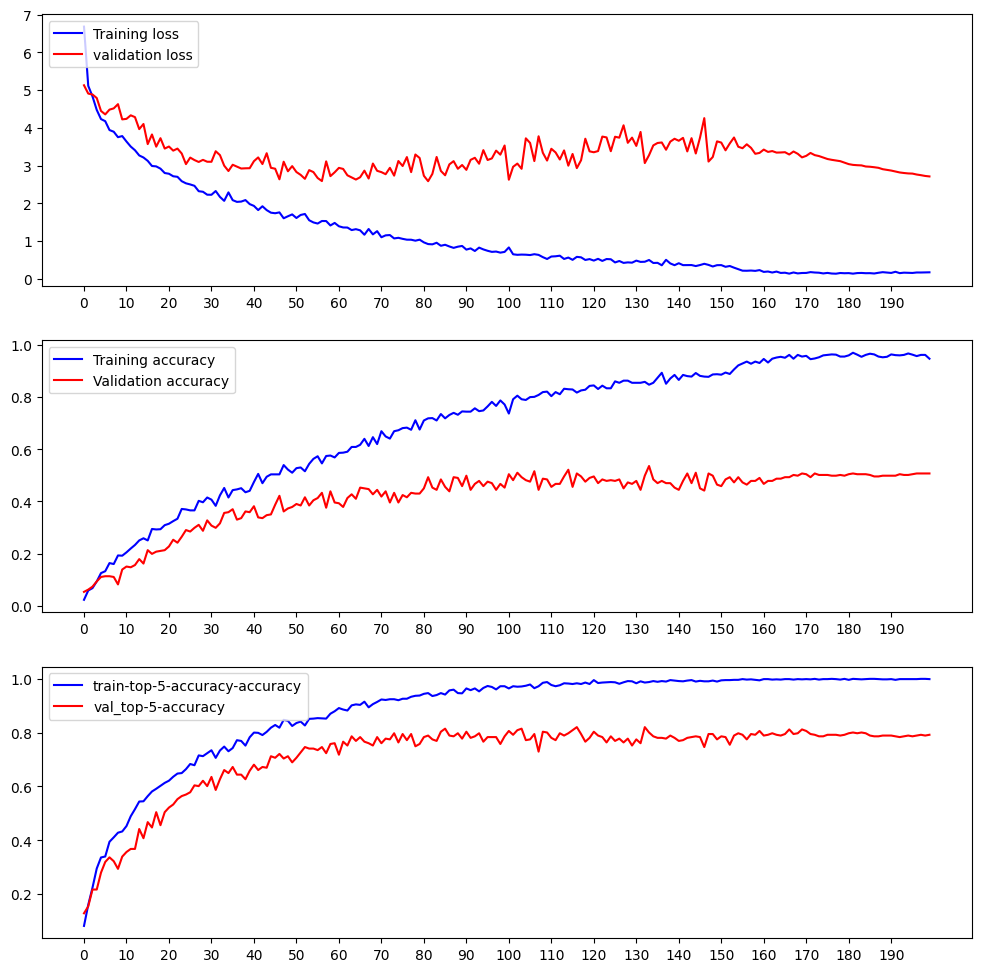

In [ ]:
grafik_adresi = os.path.join(model_kayit_noktasi_adresi, "Grafik.png")

try:
        
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(0, EPOCHS, 10))
    ax1.legend(loc='upper left')

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(0, EPOCHS, 10))
    ax2.legend(loc='upper left')

    ax3.plot(history.history['top-5-accuracy'], color='b',label="train-top-5-accuracy-accuracy")
    ax3.plot(history.history['val_top-5-accuracy'], color='r',label="val_top-5-accuracy")
    ax3.set_xticks(np.arange(0, EPOCHS, 10))
    ax3.legend(loc='upper left')
    plt.savefig(grafik_adresi, bbox_inches='tight', facecolor='w')
    plt.show()

except Exception as e:
    print(f"Grafik çizilemedi {e}")